<a href="https://colab.research.google.com/github/Vakhranev/Compling/blob/master/Vakranyov_AY_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py

import math
import numpy as np

from tqdm import tqdm

import torch

import zipfile

import seaborn as sns

from data import Downloader, Parser

--2020-10-29 09:10:29--  https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10563 (10K) [text/plain]
Saving to: ‘data.py’

data.py             100%[===================>]  10.32K  --.-KB/s    in 0s      

2020-10-29 09:10:30 (79.7 MB/s) - ‘data.py’ saved [10563/10563]



### Загружаем файл с эмбеддингами для английского языка
Они нам понадобятся чуть позже.  
Для других языков можете найти здесь: https://fasttext.cc/docs/en/crawl-vectors.html

In [ ]:
# раскомментируйте и скачайте
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-10-29 09:11:24--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  24.1MB/s    in 28s     

2020-10-29 09:11:52 (23.4 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [ ]:
# путь к данным
data_path = './data/'

### Читалка данные
Не стоит вдаваться в подробности, просто эта штука скачивает данные, затем парсит и делает из них три датасета:
- тренировочный
- валидационный
- неразмеченный

Неразмеченные данные необазятельны, но могут вам понадобиться, например, для языковой модели или улучшения эмбеддингов.

In [ ]:
downloader = Downloader(data_path=data_path)

In [ ]:
downloader.run()

multiple: 100%|██████████| 17/17 [00:18<00:00,  1.08s/it]


In [ ]:
parser = Parser(data_path=data_path)

In [ ]:
unlabeled, train, valid = parser.run()

Reading: 100%|██████████| 38/38 [02:44<00:00,  4.33s/it]


### Посмотрим на датасеты

In [ ]:
unlabeled

,question,response
0,the seller replied that the knife was made in ...,england
1,can the ringer be totally turned off? this is ...,yes it can be turned off and not ring at all
2,will this phone work with consumer cellular' s...,i just switched to consumer cellular and all f...
3,how quickly does this printer go through ink w...,"i've never measured it, but you do get a good ..."
4,will this device allow me to surfer the intern...,you can but you need to attach a compatible 3g...
...,...,...
137275,it says minimum weight 60lbs and maximum weigh...,the manual says up to 50 lbs.
137276,does this version have a limited number of use...,i was wondering the same thing & couldn't find...
137277,supposedly this is the newer model accortding ...,just the colour and our cats don't seem to not...
137278,what is the height of the back rest only?,24 inches.


In [ ]:
train

,question,response,category
0,does this fit my 99 grand caravan 3.3 engine,"yes, i used this kit in my 99 dodge grand cara...",automotive
1,does the noot battery work on the alcatel onet...,i dont know the answer to your specific questi...,cell phones and accessories
2,what is the seat back height? thank you!,15 inches above the seat,sports and outdoors
3,would a heating pad work in this or would it b...,hinot so sure a heating pad would work as the ...,pet supplies
4,are these glass or plastic?,they are bpa free plastic.,beauty
...,...,...,...
249995,what voltage is this? stationed in europe and ...,it's dc 120 v.,baby
249996,is it possible to set up play with single goal...,no. the corners are flat so you need 3 people ...,sports and outdoors
249997,will this work for a sierria 25831035,real good fit. almost to good to be true,automotive
249998,will the ear plugs fit with it in the case?,yes apple's earphones should fit perfectly. ha...,cell phones and accessories


In [ ]:
valid

,question,response,category
0,what guage steel? galvanized inside and out? ...,"hi howard, i have no idea of the answers to yo...",sports and outdoors
1,will it fit on a 5'2' teen age girl?,"absolutely, my son is 5'10"" and it works wonde...",sports and outdoors
2,does this kit also contain a piece to cover th...,yes. there are three side pieces that meet at ...,cell phones and accessories
3,does anyone know the width between the legs?,about 14 inches,office products
4,is it fast,not sure i can answer that- i bought it for my...,sports and outdoors
...,...,...,...
49995,why are these being sold without a front calip...,my only guess is because everyone uses a diffe...,sports and outdoors
49996,how long before you began to notice a differen...,after 30 days my dog was hardly shedding at al...,pet supplies
49997,what are the entire ingredients?,"purified water, vegetable glycerine, polydextr...",grocery and gourmet food
49998,does anyone know is this offer for just 1 grip...,a pair.,sports and outdoors


## Задача
Классифицировать поле question в одну из категорий в поле category.  
Это данные с сервиса Amazon QA, то есть такой сервис, на котором можно задать вопрос и получить ответ от других пользователей.

Идея задачи такая: давайте поможем клиенту определить в какую категорию выложить его вопрос, чтобы быстрее получить максимально релевантный ответ.

### Перевод класса в индекс
Мы сделаем некоторый маппер, который текст класса переводит в конкретный уникальный индекс. Нам это понадобиться, потому что наша 
модель работает не напрямую с классом, а с его индексом.

In [ ]:
# проверим, что в трейне и валидации одинаковые категории
set(train.category.unique().tolist()) == set(valid.category.unique().tolist())

True

In [ ]:
unique_categories = set(train.category.unique().tolist() + valid.category.unique().tolist())

In [ ]:
category2index = {category: index for index, category in enumerate(unique_categories)}

In [ ]:
category2index

{'automotive': 2,
 'baby': 7,
 'beauty': 3,
 'cell phones and accessories': 5,
 'grocery and gourmet food': 4,
 'office products': 1,
 'pet supplies': 0,
 'sports and outdoors': 6}

In [ ]:
train['target'] = train.category.map(category2index)
valid['target'] = valid.category.map(category2index)

In [ ]:
train

,question,response,category,target
0,does this fit my 99 grand caravan 3.3 engine,"yes, i used this kit in my 99 dodge grand cara...",automotive,2
1,does the noot battery work on the alcatel onet...,i dont know the answer to your specific questi...,cell phones and accessories,5
2,what is the seat back height? thank you!,15 inches above the seat,sports and outdoors,6
3,would a heating pad work in this or would it b...,hinot so sure a heating pad would work as the ...,pet supplies,0
4,are these glass or plastic?,they are bpa free plastic.,beauty,3
...,...,...,...,...
249995,what voltage is this? stationed in europe and ...,it's dc 120 v.,baby,7
249996,is it possible to set up play with single goal...,no. the corners are flat so you need 3 people ...,sports and outdoors,6
249997,will this work for a sierria 25831035,real good fit. almost to good to be true,automotive,2
249998,will the ear plugs fit with it in the case?,yes apple's earphones should fit perfectly. ha...,cell phones and accessories,5


### Torch Dataset, DataLoader

Очень важная абстракция для торча.
Мы всегда будем ее использовать, чтобы работать с данными.

Dataset - класс, от которого нужно наследоваться, чтобы написать свой обработчик данных. Внутри него нужно реализовать два метода, 
о которых будет чуть ниже. То есть в данном классе вы описывает как нужно преобразовать ваши данные в торчовый формат. Перевести тексты 
в индексы слов и тд.

DataLoader - класс, который будет за вас семплировать данные батчами. Это итератор, поэтому формат работы с ним примерно такой:
```python
for batch in data_loader:
    ...
```
То есть на каждой итерации отдается по одному батчу данных. Итерирование заканчивается, когда вы пройдете все батчи.

Зачем нужны эти абстракции? Чтобы упростить и унифицировать работу с данными.
Вообще вы можете реализовать что-то свое, но это упрощение данной задачи.

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [ ]:
# просто рандомные цифры
some_data_x[:10]

array([[0.60628265, 0.81855215, 0.04032249, 0.06818204],
       [0.08811917, 0.61536487, 0.62103204, 0.19494779],
       [0.35195296, 0.70944777, 0.62643847, 0.63631257],
       [0.71273118, 0.91936826, 0.47594969, 0.71466292],
       [0.37432169, 0.05685763, 0.53775563, 0.94264564],
       [0.58276578, 0.31788819, 0.0428031 , 0.5156363 ],
       [0.84910007, 0.94583194, 0.68813621, 0.12869174],
       [0.5818313 , 0.60409125, 0.67614055, 0.72607324],
       [0.15731996, 0.1343803 , 0.65760561, 0.06068719],
       [0.16076733, 0.19466998, 0.44337541, 0.85148639]])

In [ ]:
# и классы
some_data_y

array([0, 0, 1, ..., 2, 2, 0])

### Пример надобности
Для обучения модели вам нужно подавать в нее батчи данных. Как бы могли это реализовать, если бы у нас не было Dataset и DataLoader

In [ ]:
batch_size = 16

for i_batch in range(math.ceil(some_data_x.shape[0] / batch_size)):
    
    x_batch = some_data_x[i_batch * batch_size:(i_batch + 1) * batch_size]
    y_batch = some_data_y[i_batch * batch_size:(i_batch + 1) * batch_size]
    
    x_batch = torch.tensor(x_batch)
    y_batch = torch.tensor(y_batch)
    
    break

In [ ]:
x_batch

tensor([[0.6063, 0.8186, 0.0403, 0.0682],
        [0.0881, 0.6154, 0.6210, 0.1949],
        [0.3520, 0.7094, 0.6264, 0.6363],
        [0.7127, 0.9194, 0.4759, 0.7147],
        [0.3743, 0.0569, 0.5378, 0.9426],
        [0.5828, 0.3179, 0.0428, 0.5156],
        [0.8491, 0.9458, 0.6881, 0.1287],
        [0.5818, 0.6041, 0.6761, 0.7261],
        [0.1573, 0.1344, 0.6576, 0.0607],
        [0.1608, 0.1947, 0.4434, 0.8515],
        [0.5681, 0.2333, 0.1362, 0.7040],
        [0.8181, 0.9387, 0.6319, 0.1505],
        [0.8450, 0.9160, 0.9972, 0.4855],
        [0.0020, 0.4866, 0.5789, 0.9379],
        [0.5956, 0.4314, 0.4756, 0.2258],
        [0.6579, 0.9327, 0.2660, 0.9355]], dtype=torch.float64)

In [ ]:
x_batch.shape, y_batch.shape

(torch.Size([16, 4]), torch.Size([16]))

Это достаточно простой пример. Мы смогли справиться сами, но почти всегда обработка данных для подачи ее в модель делается сложнее. 
И некоторые вещи часто нужны более одного раза, например, если мы хотим каждую эпоху шафлить наши данные, чтобы получать разные батчи.
Мы сможем это сделать, но для этого нам придется тащить с собой некоторый код из проекта в проект. К тому же совместная разработка или 
просто чтение чужого кода сильно упрощается, когда вы используете унифицированные форматы.

### Перейдем к Dataset
И обернем наши данные в этот обработчик

In [ ]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # нужно обязательно определить эту функцию
        # должна возвращать размер датасета
        # нужен для DataLoader, чтобы семплировать батчи
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # еще нужно определить этот метод
        # то есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [ ]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [ ]:
some_dataset[5], some_dataset[467]

((array([0.58276578, 0.31788819, 0.0428031 , 0.5156363 ]), 0),
 (array([0.66264582, 0.69637466, 0.0421853 , 0.77843354]), 1))

### Кажется, что смысла в этом нет, но это самый простой пример

### DataLoader
В него мы можем задать некоторые параметры, например, батч сайз и нужно ли шафлить каждый новый проход по данным эти самые данные, 
чтобы получать разные батчи, то есть по разному компоновать эти батчи

In [ ]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [ ]:
for x, y in some_loader:
    break
    
x

tensor([[0.5668, 0.3685, 0.1726, 0.8020],
        [0.9270, 0.1466, 0.1942, 0.5973],
        [0.2405, 0.9415, 0.9782, 0.3359],
        [0.4112, 0.9300, 0.8427, 0.4346],
        [0.3597, 0.9494, 0.7578, 0.4446],
        [0.9389, 0.3165, 0.8136, 0.4728],
        [0.0327, 0.3777, 0.7385, 0.8090],
        [0.0780, 0.4229, 0.0839, 0.9872],
        [0.8435, 0.2222, 0.6696, 0.2440],
        [0.2121, 0.1300, 0.9089, 0.8651],
        [0.3056, 0.6988, 0.2095, 0.7659],
        [0.5560, 0.5866, 0.0156, 0.9345],
        [0.3324, 0.3058, 0.5894, 0.6722],
        [0.3296, 0.1339, 0.0687, 0.8513],
        [0.6019, 0.6263, 0.6734, 0.8634],
        [0.1362, 0.4631, 0.0716, 0.5375]], dtype=torch.float64)

In [ ]:
x.shape

torch.Size([16, 4])

In [ ]:
for x, y in some_loader:
    pass

len(x)

15

In [ ]:
# почему 15?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

### Усложним обработчик

In [ ]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # нужно обязательно определить эту функцию
        # должна возвращать размер датасета
        # нужен для DataLoader, чтобы семплировать батчи
        
        return len(self.data_x)
    
    @staticmethod
    def pow_features(x, n=2):
        
        return x ** n
    
    @staticmethod
    def log_features(x):
        
        return np.log(x)
    
    def __getitem__(self, idx):
        
        # еще нужно определить этот метод
        # то есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x_p_2 = self.pow_features(x, n=2)
        x_p_3 = self.pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x_log = self.log_features(x)
        
        # сконкатенируем наши фичи
        x = np.concatenate([x, x_p_2, x_p_3, x_log])
        
        y = self.data_y[idx]
        
        return x, y

In [ ]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [ ]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [ ]:
for x, y in toy_loader:
    break

In [ ]:
x.shape

torch.Size([128, 16])

In [ ]:
# заметим, что мы сразу получаем торчовый формат данных, который получился из автоматического преобразования из numpy
x

tensor([[ 0.6063,  0.8186,  0.0403,  ..., -0.2002, -3.2108, -2.6856],
        [ 0.0881,  0.6154,  0.6210,  ..., -0.4855, -0.4764, -1.6350],
        [ 0.3520,  0.7094,  0.6264,  ..., -0.3433, -0.4677, -0.4521],
        ...,
        [ 0.7195,  0.6653,  0.8227,  ..., -0.4075, -0.1952, -0.0260],
        [ 0.3877,  0.0949,  0.0380,  ..., -2.3554, -3.2692, -0.3970],
        [ 0.1154,  0.5366,  0.0714,  ..., -0.6224, -2.6388, -1.1596]],
       dtype=torch.float64)

In [ ]:
y

tensor([0, 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1,
        1, 1, 0, 0, 0, 2, 2, 2, 1, 1, 2, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 2, 1, 0,
        1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 0,
        2, 0, 0, 1, 1, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 1, 1, 0, 1, 1, 2,
        0, 2, 0, 2, 0, 2, 0, 2, 1, 0, 0, 1, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2,
        0, 1, 0, 1, 0, 2, 1, 2])

In [ ]:
# сделаем небольшую модель и посчитаем лосс

model = torch.nn.Sequential(torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 3))

criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.1356678009033203

### Сделаем датасет для наших текстовых данных
Будем отдавать строку и таргет по индексу

In [ ]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        
        text = self.texts[index]
        target = self.targets[index]
        
        return text, target

In [ ]:
# подготовим данные
train_x = list(train.question)
train_y = list(train.target)

valid_x = list(valid.question)
valid_y = list(valid.target)

In [ ]:
train_dataset = TextClassificationDataset(texts=list(train.question), targets=list(train.target))

In [ ]:
# семплируем данные
text, target = train_dataset[0]

In [ ]:
text

'does this fit my 99 grand caravan 3.3 engine'

In [ ]:
target

2

### Смысл обработчика
Состоит в том, что нам нужно преобразовать наши данные в формат, который мы уже сможем передать в модель.
Сейчас у нас строки, а торч ничего не знает про строки, ему нужны тензоры.

### Загружаем эмбеддинги
Чтобы работать с текстовыми данными мы можем разбить наши строки на слова, а слова перевести в вектора. Откуда нам взять эти вектора?
Мы говорили про такой метод как word2vec и в начале этой тетрадки загружали файл с этими самыми векторами.

In [ ]:
import zipfile
import numpy as np

from tqdm import tqdm

In [ ]:
def load_embeddings(zip_path, filename, pad_token='PAD', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with zipfile.ZipFile(zip_path) as zipped_file:
        with zipped_file.open(filename) as file_object:

            vocab_size, embedding_dim = file_object.readline().decode('utf-8').strip().split()

            vocab_size = int(vocab_size)
            embedding_dim = int(embedding_dim)
            
            # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
            max_words = vocab_size if max_words <= 0 else max_words
            
            # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
            vocab[pad_token] = len(vocab)
            embeddings.append(np.zeros(embedding_dim))

            progress_bar = tqdm(total=max_words, disable=not verbose)

            for line in file_object:
                parts = line.decode('utf-8').strip().split()

                token = ' '.join(parts[:-embedding_dim]).lower()
                
                if token in vocab:
                    continue
                
                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                vocab[token] = len(vocab)
                embeddings.append(word_vector)

                progress_bar.update()
                
                if len(vocab) == max_words:
                    break

            progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [ ]:
vocab, embeddings = load_embeddings('./wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec', max_words=100_000)

100%|█████████▉| 99999/100000 [00:12<00:00, 7873.71it/s]


### Посмотрим на ближайших соседей слова по эмбеддингам

In [ ]:
index2token = {index: token for token, index in vocab.items()}

In [ ]:
emb_norms = np.linalg.norm(embeddings, axis=1)

In [ ]:
def get_k_nearest_neighbors(word, embeddings, emb_norms, vocab, index2token, k=5):
    
    if word not in vocab:
        print('Not in vocab')
        return
    
    word_index = vocab[word]

    word_vector = embeddings[word_index]
    word_vector = np.expand_dims(word_vector, 0)

    scores = (word_vector @ embeddings.T)[0]
    
    # переводим в косинусы, поделив на нормы векторов
    # эпсилон 1e-6 для того, чтобы не делить на 0
    scores = scores / (emb_norms + 1e-6) / emb_norms[word_index]
    
    # 1:k+1 потому что первый вариант это само слово
    for idx in scores.argsort()[::-1][1:k+1]:
        print(f'Слово {index2token[idx]} близко на {scores[idx]:.2f} к слову {word}')

In [ ]:
get_k_nearest_neighbors('anna', embeddings, emb_norms, vocab, index2token)

Слово maria близко на 0.73 к слову anna
Слово emma близко на 0.66 к слову anna
Слово kristina близко на 0.65 к слову anna
Слово laura близко на 0.65 к слову anna
Слово emily близко на 0.65 к слову anna


In [ ]:
get_k_nearest_neighbors('mom', embeddings, emb_norms, vocab, index2token)

Слово dad близко на 0.85 к слову mom
Слово mum близко на 0.78 к слову mom
Слово mother близко на 0.76 к слову mom
Слово moms близко на 0.75 к слову mom
Слово kid близко на 0.68 к слову mom


In [ ]:
get_k_nearest_neighbors('have', embeddings, emb_norms, vocab, index2token)

Слово has близко на 0.78 к слову have
Слово been близко на 0.75 к слову have
Слово 've близко на 0.75 к слову have
Слово had близко на 0.74 к слову have
Слово ahve близко на 0.74 к слову have


In [ ]:
get_k_nearest_neighbors('money', embeddings, emb_norms, vocab, index2token)

Слово cash близко на 0.72 к слову money
Слово funds близко на 0.72 к слову money
Слово monies близко на 0.72 к слову money
Слово moneys близко на 0.67 к слову money
Слово dosh близко на 0.63 к слову money


In [ ]:
get_k_nearest_neighbors('music', embeddings, emb_norms, vocab, index2token)

Слово musical близко на 0.71 к слову music
Слово songs близко на 0.69 к слову music
Слово tunes близко на 0.69 к слову music
Слово musics близко на 0.68 к слову music
Слово composer близко на 0.68 к слову music


### Выбор метода токенизации
У нас сейчас есть маппинг, что некоторому слову соответствует некоторый эмбеддинг этого слова.
Токенизация - процесс разбиения текста на токены, то есть части этого текста.   
Чем "слово" отличается от "токена": токен это более обобщенное понятие, то есть, например, цифра это токен

In [ ]:
# про различия подробнее можно найти, например, здесь
# https://stackoverflow.com/questions/50240029/nltk-wordpunct-tokenize-vs-word-tokenize
from nltk.tokenize import word_tokenize, wordpunct_tokenize

In [ ]:
total_n_words = 0
unknown_words = list()

for sample in tqdm(train_x):
    # токенизация по пробелу
    tokens = sample.split()
    
    for tok in tokens:
        # проверяем есть ли токен в нашем словаре
        if tok not in vocab:
            unknown_words.append(tok)
            
        total_n_words += 1
        
print(f'Мы не знаем {len(unknown_words)} слов из {total_n_words} слов в датасете')
print(f'Что составляет {len(unknown_words) * 100 / total_n_words:.2f}% датасета')
print()
print(f'Уникальных неизвестных слов: {len(set(unknown_words))}')

100%|██████████| 250000/250000 [00:01<00:00, 154712.11it/s]

Мы не знаем 512414 слов из 3602778 слов в датасете
Что составляет 14.22% датасета

Уникальных неизвестных слов: 119127


In [ ]:
total_n_words = 0
unknown_words = list()

for sample in tqdm(train_x):
    # токенизация
    tokens = wordpunct_tokenize(sample)
    
    for tok in tokens:
        # проверяем есть ли токен в нашем словаре
        if tok not in vocab:
            unknown_words.append(tok)
            
        total_n_words += 1
        
print(f'Мы не знаем {len(unknown_words)} слов из {total_n_words} слов в датасете')
print(f'Что составляет {len(unknown_words) * 100 / total_n_words:.2f}% датасета')
print()
print(f'Уникальных неизвестных слов: {len(set(unknown_words))}')

100%|██████████| 250000/250000 [00:02<00:00, 95496.56it/s]

Мы не знаем 111444 слов из 4198407 слов в датасете
Что составляет 2.65% датасета

Уникальных неизвестных слов: 36080


In [ ]:
import nltk
nltk.download('punkt')

total_n_words = 0
unknown_words = list()

for sample in tqdm(train_x):
    # токенизация
    tokens = word_tokenize(sample)
    
    for tok in tokens:
        # проверяем есть ли токен в нашем словаре
        if tok not in vocab:
            unknown_words.append(tok)
            
        total_n_words += 1
        
print(f'Мы не знаем {len(unknown_words)} слов из {total_n_words} слов в датасете')
print(f'Что составляет {len(unknown_words) * 100 / total_n_words:.2f}% датасета')
print()
print(f'Уникальных неизвестных слов: {len(set(unknown_words))}')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


100%|██████████| 250000/250000 [00:46<00:00, 5386.51it/s]

Мы не знаем 151761 слов из 4100141 слов в датасете
Что составляет 3.70% датасета

Уникальных неизвестных слов: 53830


### Результаты
- Скорость у word_tokenize сильно ниже, чем у wordpunct_tokenize
- Используя word_tokenize, мы теряем примерно 1% информации из датасета по сравнению с wordpunct_tokenize

### Выбор очевиден в сторону wordpunct_tokenize

In [ ]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        
    def __len__(self):
        return len(self.texts)
    
    def tokenization(self, text):
        
        tokens = wordpunct_tokenize(text)
        
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        
        return token_indices
    
    def __getitem__(self, index):
        
        text = self.texts[index]        
        target = self.targets[index]
        
        tokenized_text = self.tokenization(text)
        
        # переведем наши индексы токенов в торчовый тензор
        # таргет переведется самостоятельно
        tokenized_text = torch.tensor(tokenized_text)
        
        return tokenized_text, target

In [ ]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)

In [ ]:
x, y = train_dataset[5]

In [ ]:
x

tensor([ 129,  291,   20,  197, 5748,  252,  149,    3,   55,   20,   98,   15,
           2, 5748,  214,   37])

In [ ]:
y

5

In [ ]:
# мы можем восстановить текст обратно по индексам слов
[index2token[idx.item()] for idx in x]

['even',
 'though',
 'it',
 'says',
 'iphone',
 '5',
 'case',
 '.',
 'will',
 'it',
 'work',
 'for',
 'the',
 'iphone',
 '4',
 '?']

### У нас остается проблема разных длин текстов
Чтобы поместить батч текстов в один тензор нам нужны одинаковые длины

In [ ]:
## это не отработает, можете раскомментировать и проверить

# x = [
#     [1, 2, 3],
#     [1, 2, 3, 4, 5],
#     [1, 2, 3, 4, 5, 6, 7]
# ]

# torch.tensor(x), torch.tensor(x).shape

In [ ]:
# это сработает

x = [
    [1, 2, 3, 0, 0, 0, 0],
    [1, 2, 3, 4, 5, 0, 0],
    [1, 2, 3, 4, 5, 6, 7]
]

torch.tensor(x), torch.tensor(x).shape

(tensor([[1, 2, 3, 0, 0, 0, 0],
         [1, 2, 3, 4, 5, 0, 0],
         [1, 2, 3, 4, 5, 6, 7]]), torch.Size([3, 7]))

### Длина текста
Нам нужно понять до какой длины нам падить каждый наш пример. 
Мы можем найти в наших данных максимальную длину примера в токенах и падить до этой длины, но у этого подхода есть минус:
у нас могут быть несколько текстов с аномально большой длиной, то есть некоторые выбросы.  

В таком случае нам легче ограничить длину этих текстов до определенной статистики по нашему датасет, то есть, например, 95% наших текстов
длиной в 25 слов и нам этого достаточно. То есть мы ограничимся этой длиной, потому что почти весь датасет влезает в эту длину
и нам не нужно будет падить до большой длины.

Паддинг нужен нам для того, чтобы мы могли поместить разные примеры в один батч, но мы не хотим учитывать эти токены, то есть 
по сути это будут холостые прогоны и за счет этого компромисса, что бОльшая часть датасета не больше n слов мы можем оптимизировать 
наше обучение.

<br>


> Почему бы нам просто не выкинуть эти длинные тексты?

Дело в том, что мы хотим прийти к некоторому компромиссу между максимальной длиной и потерей информации. Если мы возьмем 95-й перцинтиль наших длин (то есть 95% наших текстов не больше n), то, выкинув остальные 5%, мы потеряем существенную часть примеров.
С другой стороны может показаться неправильным ограничение длины и это действительно может сломать смысл примеры, но зачастую этим 
принебрегают.

In [ ]:
train_lengths = [len(wordpunct_tokenize(sample)) for sample in tqdm(train_x)]

100%|██████████| 250000/250000 [00:01<00:00, 189769.86it/s]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


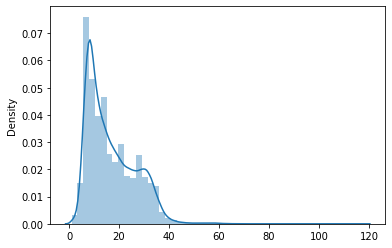

In [ ]:
sns.distplot(train_lengths)

In [ ]:
# видим большие выбросы в данных
# 97% наших текстов не больше вот стольки токенов
np.percentile(train_lengths, 95)

34.0

In [ ]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab, pad_index=0, max_length=32):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        
        self.pad_index = pad_index
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def tokenization(self, text):
        
        tokens = wordpunct_tokenize(text)
        
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        
        return token_indices
    
    def padding(self, tokenized_text):
        
        tokenized_text = tokenized_text[:self.max_length]
        
        tokenized_text += [self.pad_index] * (self.max_length - len(tokenized_text))
        
        return tokenized_text
    
    def __getitem__(self, index):
        
        text = self.texts[index]        
        target = self.targets[index]
        
        tokenized_text = self.tokenization(text)
        tokenized_text = self.padding(tokenized_text)
        
        tokenized_text = torch.tensor(tokenized_text)
        
        return tokenized_text, target

In [ ]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)

In [ ]:
x, y = train_dataset[0]
x

tensor([  218,    29,  1663,    92,  5101,  3294, 20749,   161,     3,   161,
         1861,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [ ]:
[index2token[idx.item()] for idx in x]

['does',
 'this',
 'fit',
 'my',
 '99',
 'grand',
 'caravan',
 '3',
 '.',
 '3',
 'engine',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [ ]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
valid_dataset = TextClassificationDataset(texts=valid_x, targets=valid_y, vocab=vocab)

train_loader = DataLoader(train_dataset, batch_size=128)
valid_loader = DataLoader(valid_dataset, batch_size=128)

In [ ]:
for x, y in train_loader:
    break

In [ ]:
x.shape, y.shape

(torch.Size([128, 32]), torch.Size([128]))

### Как мы можем задавать слои

In [ ]:
from torch import nn

In [ ]:
embedding_layer = nn.Embedding(num_embeddings=len(vocab), 
                               embedding_dim=embeddings.shape[-1],
                               padding_idx=0)

In [ ]:
x_embed = embedding_layer(x)

In [ ]:
x_embed

tensor([[[-3.7906, -1.5192,  0.0497,  ..., -1.2339,  0.6187,  1.5402],
         [ 1.3650,  1.6287,  0.0192,  ...,  1.0747,  1.3890,  1.0202],
         [-0.0459,  0.1610,  0.7346,  ..., -1.2025,  0.1559,  1.2280],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-3.7906, -1.5192,  0.0497,  ..., -1.2339,  0.6187,  1.5402],
         [-0.1489,  1.3007,  0.0977,  ...,  0.2390, -0.5938, -1.2195],
         [-0.6607, -1.7661,  1.8397,  ..., -0.6314,  0.4997,  1.3668],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 1.0658, -0.9167,  0.4288,  ..., -0.5357,  0.6898, -0.8597],
         [ 0.8172,  0.6538,  0.1417,  ...,  0

In [ ]:
x_embed.shape

torch.Size([128, 32, 300])

### Но мы ведь прочитали нашу матрицу эмбеддингов
Таким образом она инициализируется предобученными весами.  
При такой инициализации по умолчанию она замораживается, внутри ```.from_pretrained(embeddings, padding_idx=0)``` есть флаг ```freeze```, который отвечает за необходимость заморозки весов. То есть эти веса в процессе обучения не будут обновляться.

In [ ]:
embeddings = torch.tensor(embeddings).float()

In [ ]:
embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)

In [ ]:
x_embed = embedding_layer(x)

### Немного LSTM
Ниже будет про ```batch_first=True```

In [ ]:
lstm = nn.LSTM(input_size=300, hidden_size=128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)

In [ ]:
x_lstm, _ = lstm(x_embed)

In [ ]:
# 256 потому что это конкатенация лстмки, которая прочитала текст слева направо
# и лстмки, которая прочитала текст справа налево
x_lstm.shape

torch.Size([128, 32, 256])

In [ ]:
# избавились от временной размерности
x_lstm.mean(dim=1).shape

torch.Size([128, 256])

### Сделаем свою сеть
В первой домашке в конце есть более подробная информация почему мы используем классы.

In [ ]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, embeddings, linear_1_size, linear_2_size, n_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        
        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
        
        self.linear_1 = nn.Linear(in_features=embeddings.shape[-1], out_features=linear_1_size)
        self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
        self.linear_3 = nn.Linear(in_features=linear_2_size, out_features=n_classes)
        
    def forward(self, x):
        
        # переводим индексы слов в эмбеддинги этих слов
        # (batch_size, sequence_length) -> (batch_size, sequence_length, embedding_dim)
        x = self.embedding_layer(x)
        
        # агрегируем наши эмбеддинги по размерности время
        # (batch_size, sequence_length, embedding_dim) -> (batch_size, embedding_dim)
        x = x.sum(dim=1)
        
        # делаем нормирование
        # (batch_size, embedding_dim) -> (batch_size, embedding_dim)
        x = self.batch_norm(x)
        
        # прогоняем через первый линейный слой
        # (batch_size, embedding_dim) -> (batch_size, linear_1_size)
        x = self.linear_1(x)
        
        # применяем нелинейность
        # (batch_size, linear_1_size) -> (batch_size, linear_1_size)
        x = torch.relu(x)
        
        # прогоняем через второй линейный слой
        # (batch_size, linear_1_size) -> (batch_size, linear_2_size)
        x = self.linear_2(x)
        
        # применяем нелинейность
        # (batch_size, linear_2_size) -> (batch_size, linear_2_size)
        x = torch.relu(x)
        
        # переводим с помощью линейного преобразования в количество классов
        # (batch_size, linear_2_size) -> (batch_size, n_classes)
        x = self.linear_3(x)
        
        ## по идеи здесь должен был быть софтмакс
        ## но мы будем использовать лосс nn.CrossEntropyLoss()
        ## в его документации написано
        ## This criterion combines :func:`nn.LogSoftmax` and :func:`nn.NLLLoss` in one single class.
        ## это некоторая оптимизация, которая включает в себя сразу и софтмакс и сам negative log likelihood лосс
        ## так как у нас в лоссе есть софтмакс, то мы не будем применять его в сетке
        ## на этапе предсказания (а не обучения) мы будем отдельно делать софтмакс для получения распределения классов
        ## 
        ## (batch_size, n_classes) -> (batch_size, n_classes)
        # x = torch.softmax(x, dim=-1)
        
        return x

In [ ]:
model = DeepAverageNetwork(embeddings=embeddings,
                           linear_1_size=256, 
                           linear_2_size=128, 
                           n_classes=len(category2index))

In [ ]:
criterion = nn.CrossEntropyLoss()

# задайте оптимизатор
optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())
#изменили learning rate

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1, last_epoch=-1)
#Создаём шедуллер, который уменьшает скорость обучения каждой группы параметров на гамму каждые step_size эпохи

### Напишите цикл обучения
Что он должен в себя включать:
1. Получение предсказаний модели
1. Расчет функции потерь
1. Расчет градиентов
1. Шаг градиентного спуска
1. Обнуление градиентов
1. Записывание значения лосса

In [ ]:
losses = list()

# в обучении моделей у нас есть такая ситуация, что некоторые слои ведут себя по разному на этапе тренировки и предсказания
# например, батч норм (а так же все остальные нормировки) и дропаут
# это переводит модель в режим тренировки
model.train()
for x, y in train_loader:
  prediction = model.forward(x)
  loss = criterion(prediction, y)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  losses.append(loss)
print(f"Train loss: {loss}")

Train loss: 0.44254109263420105


In [ ]:
print(losses)

[tensor(0.7959, grad_fn=<NllLossBackward>), tensor(1.0093, grad_fn=<NllLossBackward>), tensor(1.0415, grad_fn=<NllLossBackward>), tensor(0.9629, grad_fn=<NllLossBackward>), tensor(0.8426, grad_fn=<NllLossBackward>), tensor(0.9622, grad_fn=<NllLossBackward>), tensor(1.0099, grad_fn=<NllLossBackward>), tensor(1.0994, grad_fn=<NllLossBackward>), tensor(0.9274, grad_fn=<NllLossBackward>), tensor(0.8886, grad_fn=<NllLossBackward>), tensor(0.8682, grad_fn=<NllLossBackward>), tensor(1.0486, grad_fn=<NllLossBackward>), tensor(1.0450, grad_fn=<NllLossBackward>), tensor(0.9308, grad_fn=<NllLossBackward>), tensor(1.0532, grad_fn=<NllLossBackward>), tensor(0.8844, grad_fn=<NllLossBackward>), tensor(1.0519, grad_fn=<NllLossBackward>), tensor(1.0359, grad_fn=<NllLossBackward>), tensor(0.9406, grad_fn=<NllLossBackward>), tensor(1.0331, grad_fn=<NllLossBackward>), tensor(0.9551, grad_fn=<NllLossBackward>), tensor(0.9681, grad_fn=<NllLossBackward>), tensor(0.9040, grad_fn=<NllLossBackward>), tensor(0.8

### Напишите цикл валидации
Что он должен в себя включать:
1. Получение предсказаний модели
1. Расчет функции потерь
1. Записывание значения лосса

Также с помощью контекста ```with torch.no_grad():``` можно явно указать торчу не сохранять необходимые параметры для расчета градиентов. Обязательно для режима предсказания.

In [ ]:
losses = list()

# это переводит модель в режим предсказания
# то есть фиксируются статистики батч норма, дропаут не выкидывает фичи
model.eval()

# заметьте, что мы поменяли наш лоадер на валидационный
for x, y in valid_loader:
    
    with torch.no_grad():
        # получение предсказаний модели
        # расчет лосса
        prediction = model.forward(x)
        soft_pred = torch.softmax(prediction, dim=-1)
        loss = criterion(soft_pred, y)
        losses.append(loss)
print(f"Validation loss: {loss}")

Validation loss: 1.64153254032135


In [ ]:
print(losses)

[tensor(1.5998), tensor(1.5964), tensor(1.6334), tensor(1.7022), tensor(1.6320), tensor(1.6187), tensor(1.6254), tensor(1.6774), tensor(1.6107), tensor(1.6250), tensor(1.5697), tensor(1.6126), tensor(1.5893), tensor(1.6721), tensor(1.6163), tensor(1.6124), tensor(1.6897), tensor(1.6053), tensor(1.6464), tensor(1.6765), tensor(1.6763), tensor(1.5916), tensor(1.6280), tensor(1.6227), tensor(1.6573), tensor(1.6653), tensor(1.6887), tensor(1.6624), tensor(1.6985), tensor(1.6531), tensor(1.6218), tensor(1.6491), tensor(1.6612), tensor(1.6744), tensor(1.6394), tensor(1.6899), tensor(1.7193), tensor(1.6749), tensor(1.6213), tensor(1.6562), tensor(1.6666), tensor(1.6583), tensor(1.6209), tensor(1.7025), tensor(1.6226), tensor(1.6880), tensor(1.6352), tensor(1.6961), tensor(1.6774), tensor(1.6508), tensor(1.6921), tensor(1.6533), tensor(1.6665), tensor(1.6394), tensor(1.6392), tensor(1.5897), tensor(1.6425), tensor(1.6405), tensor(1.6861), tensor(1.6372), tensor(1.7351), tensor(1.6501), tensor(

### Проведите обучение несколько эпох
Одна эпоха - это один проход по датасету.  
Шаги:
- Поменяйте что-нибудь в модели, добавить дропаут и тд
- Остановите обучение с помощью early stopping
- Добавьте расчет метрик во время обучения и предсказания (например, micro F1). Чтобы это сделать вы можете, например, сохранять предсказания модели
- После обучения нарисуйте как по мере обучения меняется функция потерь на тренировочном и валидационном датасете, как меняется метрики
- Опционально: постройте confusion matrix

Подсказки:
- Чтобы корректно сохранять предсказания нужно переменную отсоединить от графа, то есть сделать ```x.detach()```

In [ ]:
!pip install pytorch_lightning
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [ ]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, embeddings, linear_1_size, linear_2_size, n_classes, loss):
        super().__init__()
        self.log('train_loss', loss)
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        self.dropout = nn.Dropout(p=0.1)
        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
        self.linear_1 = nn.Linear(in_features=embeddings.shape[-1], out_features=linear_1_size)
        self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
        self.linear_3 = nn.Linear(in_features=linear_2_size, out_features=n_classes)
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = x.sum(dim=1)
        x = self.batch_norm(x)
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.linear_2(x)
        x = torch.relu(x)
        x = self.linear_3(x)
        return x

In [ ]:
losses = list()
trainer = Trainer(callbacks=[EarlyStopping(monitor='val_loss')])
model.train()
for n_epoch in range(2):
  for x, y in train_loader:
    prediction = model.forward(x)
    loss = criterion(prediction, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss)
  print(f"Train loss: {loss}")
  for x, y in valid_loader:
    with torch.no_grad():
      prediction = model.forward(x)
      soft_pred = torch.softmax(prediction, dim=-1)
      loss = criterion(soft_pred, y)
      losses.append(loss)
  print(f"Validation loss: {loss}")

### Важные и не очень интуитивные моменты про LSTM и CNN в торче

По умолчанию LSTM принимает данные с такой размерностью:
```python
(seq_len, batch, input_size)
```
Сделано это с целью оптимизации на более низком уровне.  
Мы оперируем такими объектами:
```python
(batch, seq_len, input_size)
```
Чтобы LSTM у нас заработала правильно, мы можем либо передать параметр ```batch_first=True``` во время инициализации слоя,
либо транспонировать (поменять) первую и вторую размерность у нашего x перед подачей в слой.  
[Подробнее про LSTM](https://pytorch.org/docs/stable/nn.html#lstm)

- 128 - размер батча
- 64 - длина последовательности (количество слов)
- 1024 - эмбеддинг слова

In [ ]:
x = torch.rand(128, 64, 1024)

In [ ]:
# первый способ
lstm = torch.nn.LSTM(1024, 512, batch_first=True)

pred, mem = lstm(x)

In [ ]:
pred.shape

In [ ]:
# второй способ
lstm = torch.nn.LSTM(1024, 512)

# меняем размерность batch и seq_len местами
x_transposed = x.transpose(0, 1)
pred_transposed, mem = lstm(x_transposed)

In [ ]:
# у нас все еще осталась размерность (seq_len, batch, input_size)
pred_transposed.shape

In [ ]:
# просто транспонируем еще раз
pred = pred_transposed.transpose(0, 1)
pred.shape

### Conv1d & MaxPool1d
Примерно такая же ситуация происходит со сверточными слоями и пулингами.  
1d реализация как раз для текстов, в ней матрица-фильтр ходит только по одной размерности.  
[Подробнее про CNN](https://pytorch.org/docs/stable/nn.html#conv1d)  
[Подробнее про пулинг](https://pytorch.org/docs/stable/nn.html#maxpool1d)  
Ожидается такая размерность:
```python
(batch, input_size, seq_len)
```
Мы все еще хоти подавать такую размерность:
```python
(batch, seq_len, input_size)
```
В случае со свертками и пулингами у нас есть вариант только транспонировать x перед подачей и транспонировать полученный результат. Обратите внимание, что транспонируем мы первую и вторую размерность (индексация с нуля).

In [ ]:
x.shape

In [ ]:
# in_channels - размер входных эмбеддингов
# out_channels - количество/какой размер эмбеддингов мы хотим получить
# kernel_size - размер окна/н-граммы
cnn = torch.nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=3)

In [ ]:
# выпадет ошибка, посмотрите какая
# pred = cnn(x)

In [ ]:
x_transposed = x.transpose(1, 2)
x_transposed.shape
# перевели в (batch, input_size, seq_len)

In [ ]:
pred_transposed = cnn(x_transposed)
pred_transposed.shape
# осталась разрмерность (batch, output_size, seq_len)

In [ ]:
# переведем обратно в (batch, seq_len, input_size)
pred = pred_transposed.transpose(1, 2)
pred.shape

### Еще важный момент про LSTM

The input can also be a packed variable length sequence. See [torch.nn.utils.rnn.pack_padded_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence) or [torch.nn.utils.rnn.pack_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_sequence) for details.

Это внутренняя конструкция торча, которая позволяет не читать токен ```PAD```, но все еще работать с батчами. То есть внутри батча мы можем передать лстмке, что у нас данные переменной длины. Не забудьте что на выход отдается [torch.nn.utils.rnn.PackedSequence](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.PackedSequence).

## Домашнее задание

1. Сделать класс нейронки, вписать необходимые операции, архитектура ниже
1. Написать обучалку (обобщить то, что было выше)
1. Добавить логирование
    1. Сохранять лосс на каждой итерции обучения __0.25 балла__
    1. Каждую эпоху сохранять лосс трейна и тест __0.25 балла__
    1. Каждую эпоху рассчитывать метрики __0.25 балла__
    1. Добавить прогресс бар, в котором показывается усредненный лосс последних 500-та итераций __0.25 балла__
1. Добавить early stopping __0.5 балла__
1. Нарисовать графики лосса, метрик, конфьюжин матрицу __0.5 балла__


### Архитектура (что можно попробовать)
1. Предобученные эмбеддинги. Почитайте [здесь](https://pytorch.org/docs/stable/nn.html#embedding) (from_pretrained) как вставить свои эмбеддинги, выше мы читали матрицу эмбеддингов. __0 баллов__
1. Дообучить эмбеддинги отдельно от сети. __2 балла__
1. Дообучить эмбеддинги вместе с сетью и с другим learning rate (указывается в оптимизаторе). __2 балла__
1. Bidirectional LSTM. __1 балл__
1. Несколько параллельных CNN с разными размерами окна и mean/max over time пулингами к ним и дальнейшей конкатенацией. __2 балла__
1. Несколько последовательных CNN. __1 балла__
1. Разные окна и residual к предыдущему пункту. __2 балла__
1. Предыдущий пункт сделан без ошибок (замаскированы свертки паддингов). __2 балла__
1. Написать правильный правильный mean/max пулинг, который не учитывает паддинги, точнее их маскирует. __2 балла__
1. Добавить [torch.nn.utils.rnn.pack_padded_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence) и [torch.nn.utils.rnn.pack_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_sequence) для LSTM. Инфа [здесь](#Еще-важный-момент-про-LSTM) __2 балла__
1. Добавить spatial дропаут для входа LSTM (не просто стандартный пункт при инициализации LSTM) __1 балл__
1. Добавить BatchNorm/LayerNorm/Dropout/Residual/etc __1 балл__
1. Добавить шедуллер __1 балл__
1. Обучать на GPU __2 балла__
1. Сделать transfer learning с собственно обученной языковой модели, обученной на любых данных, например, unlabeled. __7 баллов__
1. your madness

## 10 баллов максимум

# По итогам напишите результаты экспериментов
# Что получилось, а что нет
# Почему, выводы